In [1]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner

import jax
import jax.numpy as jnp
import numpyro

In [2]:
def signal_model(t, amplitude):
    return jnp.sin(t) * amplitude

In [3]:
def noise_model(mean = 0, variance = 1):
    return numpyro.distributions.Normal(loc = mean, scale = variance**0.5)

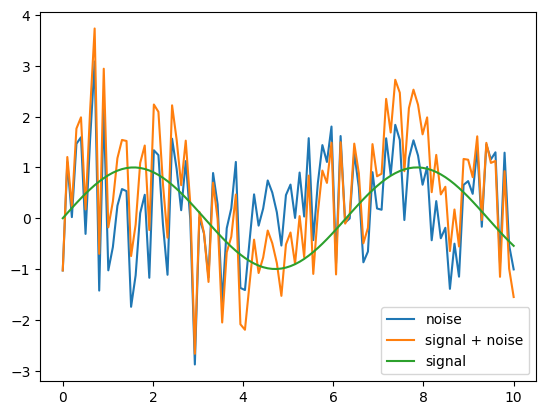

In [4]:
N = 100
amplitude = 1
mean = 0
variance = 1

t = np.linspace(0, 10, N)
signal = signal_model(t, amplitude)

with numpyro.handlers.seed(rng_seed = 0):
    with numpyro.plate('N', N):
        noise = numpyro.sample('noise', noise_model(mean, variance))

plt.plot(t, noise, label = 'noise')
plt.plot(t, signal + noise, label = 'signal + noise')
plt.plot(t, signal, label = 'signal')
plt.legend()

In [5]:
def model(t, data):
    amplitude = numpyro.sample('amplitude', numpyro.distributions.Uniform(0, 20))
    signal = signal_model(t, amplitude)
    variance = numpyro.sample('variance', numpyro.distributions.Uniform(0, 20))
    with numpyro.plate('N', t.size):
        numpyro.sample('noise', noise_model(variance = variance), obs = data - signal)

In [6]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup = 10_000, num_samples = 10_000)
mcmc.run(jax.random.PRNGKey(1), t = t, data = signal + noise)
mcmc.print_summary()

sample: 100%|█████| 20000/20000 [00:08<00:00, 2352.77it/s, 7 steps of size 8.21e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  amplitude      1.20      0.16      1.20      0.94      1.46   7355.38      1.00
   variance      1.17      0.17      1.16      0.90      1.44   7400.37      1.00

Number of divergences: 0


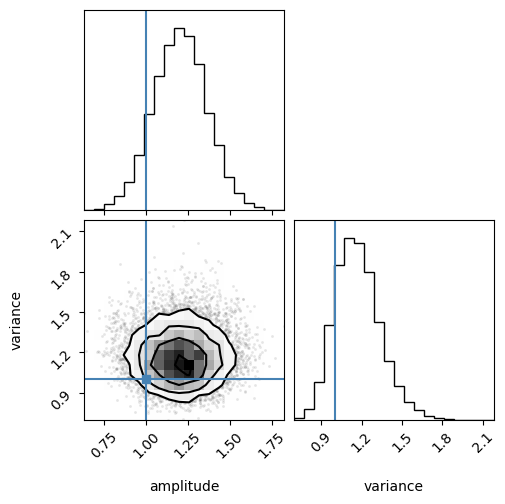

In [7]:
corner(
    np.atleast_2d(list(mcmc.get_samples().values())).T,
    truths = [amplitude, variance],
    labels = list(mcmc.get_samples()),
);